# $\Lambda_b \rightarrow pK\mu\tau$ documentation: geometrical cuts and BDT

We see when plotting the B mass that there is a problem in the $\tau$ reconstruction: we see masses which can go up to several hundreds of thousands of MeVs.
This can be due to muons being close to the plane used in the data reconstruction, or to large errors leading the $\tau$ to be at random places, which might not be valid.
Below, we explore geometrical cuts which help us solve the problem, then we go on to apply a BDT on the data in order to remove background.

RangeIndex(start=0, stop=148967, step=1)
148967
138036
118218
104944
102866
True id tests done
79252
78377
77076
76132
34921
34921
34921
jpsi events 239
jpsi events from Lb 0
comp 0 back 22
33876
0.5878358429288456
0.46495423678771775
0.5021545363319757
0.3861047163685733
0.544987601842012
0.3828016643550624
0.36728971962616824
0.3276699029126214
945
data frame length: 945, FD 90th percentile: 50.85352778177634


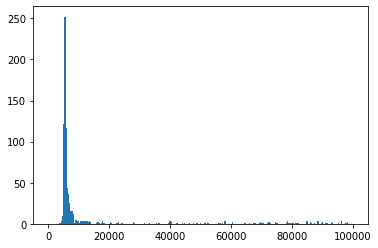

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from background_reduction.b_MC_reduction import b_cleaning
from data.data_loader import load_data
from get_vertex import obtain_lb_line_of_flight, transverse_momentum, line_plane_intersection, tau_momentum_mass
from masses import get_mass

data_frame_b = load_data(df_name='B_MC')
data_frame_b.dropna(inplace=True)
data_frame_b = b_cleaning(data_frame_b)
data_frame_b = data_frame_b.reset_index(drop=True)
data_frame_b = obtain_lb_line_of_flight(data_frame_b)
data_frame_b = transverse_momentum(data_frame_b)
data_frame_b = line_plane_intersection(data_frame_b)
data_frame_b = tau_momentum_mass(data_frame_b)

particles_associations = [['Kminus_P', 'K'], ['proton_P', 'pi'], ['mu1_P', 'mu'], ['tau_P', 'tau']]
data_frame_b['b_mass'] = get_mass(data_frame=data_frame_b, particles_associations=particles_associations)
plt.hist(data_frame_b['b_mass'], bins='auto', range=[0, 100000])
plt.show()
data_frame_b['B mass region'] = 'middle'
data_frame_b.loc[data_frame_b['b_mass'] < 8000, 'B mass region'] = 'low'
data_frame_b.loc[data_frame_b['b_mass'] > 28000, 'B mass region'] = 'high'

## Geometrical cuts
Several cuts were applied based on the geometry of the problem, after having first been tested on the B Monte Carlo data.
This allowed us to avoid huge $pK\mu\tau$ mass reconstructions.

### $\tau$ and $pK\mu$ alignment
We expect the $\tau$ and the $pK\mu$ to be on opposite sides of the $\Lambda_b$ line of flight.
If this was not the case, momentum could not be conserved. 
As such, if we observe from the reconstruction of the $\tau$ direction that the $\tau$ and $pK\mu$ are on the same side of the $\Lambda_b$ line of flight (aka they are `aligned`), we can deduce that our reconstruction was wrong.
This reconstruction can be wrong for several reasons, one of those being that the muon is at a low angle to the $\Lambda_b$/$pK\mu$ plane, yielding false and improbable results.
We see that bad reconstructions mostly lead to high $pK\mu\tau$ masses, but some seemingly fine events at low $pK\mu\tau$ masses also had bad $\tau$ direction reconstrutions.
Hence only events with the correct `alignment` were kept.

(array([-1.,  1.]), array([332, 613], dtype=int64))


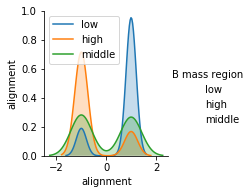

In [2]:
tau_decay_points = data_frame_b['tau_decay_point'].values
pkmu_endvertex_point = data_frame_b[['pKmu_ENDVERTEX_X', 'pKmu_ENDVERTEX_Y', 'pKmu_ENDVERTEX_Z']].values.tolist()
data_frame_b['_tau_dir_x'] = [(tau_decay_points[i] - pkmu_endvertex_point[i])[0] for i in range(len(tau_decay_points))]
data_frame_b['_tau_dir_y'] = [(tau_decay_points[i] - pkmu_endvertex_point[i])[1] for i in range(len(tau_decay_points))]
data_frame_b['_tau_dir_z'] = [(tau_decay_points[i] - pkmu_endvertex_point[i])[2] for i in range(len(tau_decay_points))]
_tau_dir_vars = ['_tau_dir_x', '_tau_dir_y', '_tau_dir_z']
_tau_direction = data_frame_b.loc[:, _tau_dir_vars]
data_frame_b[_tau_dir_vars] = _tau_direction.divide((_tau_direction ** 2).sum(axis=1) ** 0.5, axis='rows')
_tau_direction = data_frame_b.loc[:, _tau_dir_vars]
_pKmu_dir_vars = ['_pKmu_dir_x', '_pKmu_dir_y', '_pKmu_dir_z']
_pKmu_direction = data_frame_b.loc[:, ['pKmu_PX', 'pKmu_PY', 'pKmu_PZ']]
data_frame_b[_pKmu_dir_vars] = _pKmu_direction.divide((_pKmu_direction ** 2).sum(axis=1) ** 0.5, axis='rows')
_pKmu_direction = data_frame_b.loc[:, _pKmu_dir_vars]
_vectors_array_dtype = data_frame_b.loc[:, 'vectors']
_vectors_array = np.vstack(_vectors_array_dtype.to_numpy())
data_frame_b.loc[:, '_lb_dir_x'] = _vectors_array[:, 0]
data_frame_b.loc[:, '_lb_dir_y'] = _vectors_array[:, 1]
data_frame_b.loc[:, '_lb_dir_z'] = _vectors_array[:, 2]
_lb_dir_vars = ['_lb_dir_x', '_lb_dir_y', '_lb_dir_z']
_lb_direction = data_frame_b.loc[:, ['_lb_dir_x', '_lb_dir_y', '_lb_dir_z']]
data_frame_b[_lb_dir_vars] = _lb_direction.divide((_lb_direction ** 2).sum(axis=1) ** 0.5, axis='rows')
_lb_direction = data_frame_b.loc[:, _lb_dir_vars]

__tau_dir = data_frame_b.loc[:, _tau_dir_vars]
__pKmu_dir = data_frame_b.loc[:, _pKmu_dir_vars]
__lb_dir = data_frame_b.loc[:, _lb_dir_vars]

__lb_dir_array = __lb_dir.to_numpy()
__pKmu_dir_array = __pKmu_dir.to_numpy()

_pKmu_longitudinal = __lb_dir_array * (__pKmu_dir_array * __lb_dir_array).sum(axis=1).reshape((-1, 1))
ideal_opposite_dir = -(__pKmu_dir_array - _pKmu_longitudinal)
alignment = (ideal_opposite_dir * __tau_dir.to_numpy()).sum(axis=1)
alignment = np.sign(alignment)
print(np.unique(alignment, return_counts=True))
data_frame_b['alignment'] = alignment

sns.pairplot(data=data_frame_b, x_vars=['alignment'], y_vars=['alignment'], hue='B mass region')
plt.legend()
plt.show()
data_frame = data_frame_b[data_frame_b['alignment'] == 1]

### Angle between tauMu direction and $\Lambda_b$ direction
We see a huge difference in angle between the tauMu direction and $\Lambda_b$ direction for high and low $\Lambda_b$ masses.
Again, if the muon is actually in the plane, we expect potential nonsensical results with the $\tau$ going backwards.
Hence, events with an angle higher than 90 degrees were removed from the data.

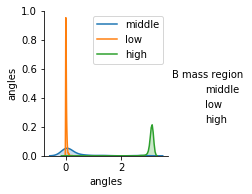

In [12]:
angles = []
for i in range(len(data_frame_b)):
    temp_series = data_frame_b.loc[i]
    end_xyz = [temp_series['pKmu_ENDVERTEX_X'], temp_series['pKmu_ENDVERTEX_Y'], temp_series['pKmu_ENDVERTEX_Z']]
    tau_vector = temp_series['tau_decay_point'] - end_xyz
    vector = temp_series['vectors']
    angle = np.arccos(np.dot(tau_vector, vector) / (np.linalg.norm(tau_vector) * np.linalg.norm(vector)))
    angles.append(angle)
    
data_frame_b['angles'] = angles
sns.pairplot(data=data_frame_b, x_vars=['angles'], y_vars=['angles'], hue='B mass region')
plt.legend()
sns.catplot(
    x="B mass region", y="angles", kind="boxen", data=data_frame_b
)
plt.show()
data_frame = data_frame[data_frame['angles'] < np.pi / 2]

## BDT
Background cleaning which did did not involve PID cuts, cleaning cuts or mass cuts was then optimised with a BDT.
The steps included:
1. Applying the cleaning to the B Monte Carlo data, using that as a signal and defining percentiles beyond which the data would be considered as background
2. Applying the same cleaning (plus PID cleaning) to the $\Lambda_b$ data and extracting background
3. Insert the cleaned B data and cleaned background to determine optimal cuts


